In [1]:
# Importing the required modules

In [2]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'Visakhapatnam']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
3485,3488,17.73,82.86,Visakhapatnam,Butchayyapeta,Chinna Madina,Black,8.32,0.39,0.71,8.15,306.0,2527.0,681.0,13.53,0.74,1.33,3.44,1.42,12.44,0.652855,0.458095,1.538462,3.652916,-0.6462,Sugarcane
3486,3489,17.73,82.86,Visakhapatnam,Butchayyapeta,Chinna Madina,Black,8.27,0.52,0.66,20.64,159.0,2541.0,937.0,39.25,0.70,1.72,34.78,3.60,3.90,0.652855,0.458095,1.538462,3.652916,-0.6462,Sugarcane
3487,3490,17.73,82.86,Visakhapatnam,Butchayyapeta,Chinna Madina,RED,8.26,0.14,0.42,12.38,231.0,711.0,299.0,3.94,0.88,1.00,4.50,0.49,10.60,0.652855,0.458095,1.538462,3.652916,-0.6462,Paddy/ Sugarcane
3488,3491,17.73,82.86,Visakhapatnam,Butchayyapeta,Chinna Madina,RED,8.09,0.16,0.27,2.83,105.0,951.0,436.0,3.50,0.54,0.83,9.86,1.05,16.68,0.652855,0.458095,1.538462,3.652916,-0.6462,Paddy/ Sugarcane
3489,3492,17.73,82.86,Visakhapatnam,Butchayyapeta,Chinna Madina,RED,7.90,0.12,0.19,5.19,42.0,449.0,150.0,2.75,0.74,0.49,10.44,0.81,14.28,0.652855,0.458095,1.538462,3.652916,-0.6462,Paddy/ Sugarcane


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'NDVI', 'EVI', 'GCI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,ARVI
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,6.809927,0.165418,0.642691,10.683745,153.418182,1239.952727,319.054545,10.000509,0.923091,0.924800,38.874036,1.968691,45.837018,0.356647
std,1.037585,0.221806,0.380173,12.766050,149.612454,710.870368,207.867186,19.193245,0.772242,0.698839,45.426617,1.161285,37.485161,0.199659
min,4.850000,0.020000,0.040000,1.620000,36.000000,250.000000,59.000000,0.630000,0.120000,0.160000,2.760000,0.420000,3.900000,-0.101546
25%,5.920000,0.060000,0.365000,3.815000,88.000000,630.500000,149.000000,2.975000,0.480000,0.510000,15.260000,1.100000,18.230000,0.205952
50%,6.610000,0.110000,0.610000,6.450000,119.000000,1068.000000,277.000000,4.970000,0.720000,0.730000,25.820000,1.840000,31.380000,0.328560
75%,7.745000,0.180000,0.800000,11.660000,169.500000,1690.500000,441.000000,9.010000,1.030000,1.140000,41.520000,2.410000,65.640000,0.505321
max,9.420000,2.520000,2.640000,101.770000,2037.000000,3617.000000,1156.000000,184.300000,5.580000,7.430000,354.700000,8.340000,256.880000,0.764706


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Black ', 'RED', '   Black', 'Red Sandy', 'Red', ' Red', 'Black  ',
       'Black', 'red sandy', 'red sandy\\', 'black sandy', 'blacksandy',
       'black sandy ', 'black', 'Red ', 'Black Sandy'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace(['Black', '   Black', 'Black  ', 'Black', 'black', 'Black '], 'Black Soil')
df['SoilType'] = df['SoilType'].replace(['RED', 'Red', ' Red', 'Red '], 'Red Soil')
df['SoilType'] = df['SoilType'].replace(['Red Sandy', 'red sandy', 'red sandy\\'], 'Red Sandy Soil')
df['SoilType'] = df['SoilType'].replace(['black sandy', 'blacksandy', 'black sandy', 'Black Sandy', 'black sandy '], 'Black Sandy Soil')
df.SoilType.unique()

array(['Black Soil', 'Red Soil', 'Red Sandy Soil', 'Black Sandy Soil'],
      dtype=object)

In [11]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Sandy Soil': 29,
 'Black Soil': 123,
 'Red Sandy Soil': 54,
 'Red Soil': 69}

<BarContainer object of 4 artists>

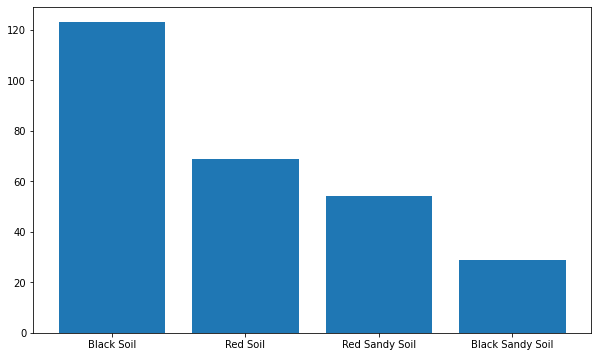

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['Sugarcane ', 'Paddy/ Sugarcane', 'Paddy', 'Sugarcane',
       'suger cane ', 'paddy', 'SUGER CANE ', 'Ragi/Niger',
       'Maize/Paddy/Rajma', 'Maize/Rajma', 'Rajma/Maize',
       'Paddy/Maize/G.N', 'Maize', 'Groundnut', 'Turmeric', 'Ragi',
       'Paddy/Maize'], dtype=object)

In [15]:
df['Crop'].value_counts()

Paddy/ Sugarcane     81
Paddy/Maize/G.N      33
Sugarcane            24
Maize/Paddy/Rajma    20
Paddy                20
suger cane           18
Paddy/Maize          16
Ragi/Niger           15
Rajma/Maize          14
Maize/Rajma          10
SUGER CANE            8
paddy                 7
Sugarcane             5
Maize                 1
Groundnut             1
Turmeric              1
Ragi                  1
Name: Crop, dtype: int64

Paddy + SugarCane    163
Paddy + Maize         70
Maize + Rajma         24
Ragi                  16
Name: Crop, dtype: int64


<BarContainer object of 4 artists>

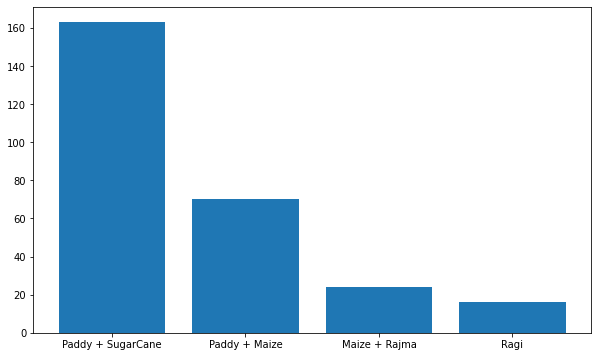

In [16]:
df['Crop'] = df['Crop'].replace(['Sugarcane ', 'Sugarcane', 'suger cane ', 'SUGER CANE '], 'SugarCane')
df['Crop'] = df['Crop'].replace(['Paddy/ Sugarcane'], 'Paddy + SugarCane')
df['Crop'] = df['Crop'].replace(['Paddy', 'paddy'], 'Paddy')
df['Crop'] = df['Crop'].replace(['Maize/Rajma', 'Rajma/Maize'], 'Maize + Rajma')
df['Crop'] = df['Crop'].replace(['Maize/Paddy/Rajma', 'Paddy/Maize/G.N', 'Maize', 'Paddy/Maize'], 'Paddy + Maize')
df['Crop'] = df['Crop'].replace(['Paddy + SugarCane', 'Paddy', 'SugarCane'], 'Paddy + SugarCane')
df['Crop'] = df['Crop'].replace('Ragi/Niger', 'Ragi')
df = df[(df['Crop'] != 'Groundnut') & (df['Crop'] != 'Turmeric')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
# Getting rid of features that have a high correlation among one another

In [18]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,ARVI
pH,1.000000,0.480688,-0.333383,0.212552,0.120609,0.635819,0.665875,0.375249,-0.112625,0.564074,-0.461003,-0.302912,-0.632308,-0.049393
EC,0.480688,1.000000,-0.113811,0.189278,0.579347,0.304698,0.353923,0.905148,0.032202,0.542661,-0.160148,-0.055957,-0.275806,0.030473
OC,-0.333383,-0.113811,1.000000,-0.003450,0.216241,0.027773,-0.158163,-0.107069,0.541595,-0.030128,0.351817,0.446556,0.573010,0.077604
P,0.212552,0.189278,-0.003450,1.000000,0.172696,0.205397,0.283987,0.143692,0.492402,0.210786,0.100140,0.104467,-0.227438,-0.250728
K,0.120609,0.579347,0.216241,0.172696,1.000000,0.062876,0.058264,0.468951,0.245236,0.173017,-0.063486,0.017689,0.071308,0.026658
Ca,0.635819,0.304698,0.027773,0.205397,0.062876,1.000000,0.806148,0.252167,0.005950,0.509460,-0.149374,0.107125,-0.313804,-0.109528
Mg,0.665875,0.353923,-0.158163,0.283987,0.058264,0.806148,1.000000,0.270701,-0.056657,0.590767,-0.130534,0.116103,-0.424087,-0.134712
S,0.375249,0.905148,-0.107069,0.143692,0.468951,0.252167,0.270701,1.000000,-0.007399,0.531710,-0.096959,0.005405,-0.218240,0.070235
Zn,-0.112625,0.032202,0.541595,0.492402,0.245236,0.005950,-0.056657,-0.007399,1.000000,-0.009086,0.416219,0.408112,0.287436,-0.115141
B,0.564074,0.542661,-0.030128,0.210786,0.173017,0.509460,0.590767,0.531710,-0.009086,1.000000,-0.149671,0.054915,-0.319448,0.004388


In [19]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)

Columns to be dropped :  ['K', 'Ca', 'Mg', 'S', 'Zn', 'B', 'Cu', 'Mn']


In [20]:
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'OC', 'P', 'Fe', 'ARVI', 'Crop']


In [21]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [22]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

        pH    EC    OC  ...  Black Soil  Red Sandy Soil  Red Soil
3485  8.32  0.39  0.71  ...           1               0         0

[1 rows x 10 columns]
3485    Paddy + SugarCane
Name: Crop, dtype: object


In [23]:
# Standardizing the independent variables using Feature Scaling
sc1 = StandardScaler()
X[:, 0:6] = sc1.fit_transform(X[:, 0:6])

In [24]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [25]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [26]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [27]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7971014492753623


In [28]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 79.90 %
Standard Deviation: 8.39 %


# Decision Tree Classifier

In [29]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [30]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [31]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8115942028985508


In [32]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 74.60 %
Standard Deviation: 8.68 %


# Random Forest Classifier

In [33]:
clf3 = RandomForestClassifier(random_state=0)
clf3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [34]:
y_test_pred = clf3.predict(X_test)
y_train_pred = clf3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [35]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.855072463768116


In [36]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 83.86 %
Standard Deviation: 7.80 %


In [37]:
# pickle.dump(clf3, open('Visakhapatnam_model.pkl', 'wb'))
# pickle.dump(sc1, open('Visakhapatnam_scaler.pkl', 'wb'))

# XGBoost

In [38]:
clf4 = HistGradientBoostingClassifier(random_state=0)
clf4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [39]:
y_test_pred = clf4.predict(X_test)
y_train_pred = clf4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [40]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8695652173913043


In [41]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4, X = X_train, y = y_train, cv = 10)

In [42]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 81.48 %
Standard Deviation: 10.92 %


In [43]:
# pickle.dump(clf4, open('Visakhapatnam_model.pkl', 'wb'))
# pickle.dump(sc1, open('Visakhapatnam_scaler.pkl', 'wb'))

# Multi-layer Perceptron Classifier

In [44]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [45]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [46]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.8578431372549019
Testing Accuracy:  0.8260869565217391


In [47]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 79.52 %
Standard Deviation: 7.51 %


# Catboost

In [48]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 0.8371259	total: 46.7ms	remaining: 4.62s
1:	learn: 0.7361164	total: 48.1ms	remaining: 2.36s
2:	learn: 0.6114966	total: 48.8ms	remaining: 1.58s
3:	learn: 0.5647809	total: 49.5ms	remaining: 1.19s
4:	learn: 0.5251831	total: 50.2ms	remaining: 953ms
5:	learn: 0.4925733	total: 52.8ms	remaining: 828ms
6:	learn: 0.4604462	total: 53.5ms	remaining: 711ms
7:	learn: 0.4405203	total: 54.2ms	remaining: 624ms
8:	learn: 0.4262871	total: 54.9ms	remaining: 555ms
9:	learn: 0.4174039	total: 55.6ms	remaining: 500ms
10:	learn: 0.3838096	total: 56.3ms	remaining: 455ms
11:	learn: 0.3478855	total: 57ms	remaining: 418ms
12:	learn: 0.3201791	total: 57.7ms	remaining: 386ms
13:	learn: 0.3042430	total: 58.4ms	remaining: 359ms
14:	learn: 0.2952225	total: 59.2ms	remaining: 335ms
15:	learn: 0.2907016	total: 59.9ms	remaining: 314ms
16:	learn: 0.2746780	total: 60.6ms	remaining: 296ms
17:	learn: 0.2715800	total: 61.9ms	remaining: 282ms
18:	learn: 0.2621240	total: 62.6ms	remaining: 267ms
19:	learn: 0.2524256	tot

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7643796531
bestIteration = 99

Training on fold [1/5]

bestTest = 0.7527199753
bestIteration = 99

Training on fold [2/5]

bestTest = 0.6582952704
bestIteration = 99

Training on fold [3/5]

bestTest = 0.6390460131
bestIteration = 99

Training on fold [4/5]

bestTest = 0.5910840799
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 1.3295539	total: 91.4ms	remaining: 30.4s
3:	learn: 1.3091894	total: 120ms	remaining: 29.9s
4:	learn: 1.2907247	total: 155ms	remaining: 30.8s
5:	learn: 1.2763798	total: 186ms	remaining: 30.8s
6:	learn: 1.2623767	total: 215ms	remaining: 30.5s
7:	learn: 1.2472856	total: 256ms	remaining: 31.7s
8:	learn: 1.2310245	total: 272ms	remaining: 29.9s
9:	learn: 1.2149680	total: 304ms	remaining: 30.1s
10:	learn: 1.1941216	total: 332ms	remaining: 29.9s
11:	learn: 1.1812259	total: 362ms	remaining: 29.8s
12:	learn: 1.1692386	total: 390ms	remaining: 29.6s
13:	learn: 1.1498405	total: 394ms	remaining: 27.8s
14:	learn: 1.1378431	total: 422ms	remaining: 27.7s
15:	learn: 1.1201988	total: 452ms	remaining: 27.8s
16:	learn: 1.1085838	total: 491ms	remaining: 28.4s
17:	learn: 1.0978483	total: 520ms	remaining: 28.4s
18:	learn: 1.0863438	total: 548ms	remaining: 28.3s
19:	learn: 1.0758985	total: 585ms	remaining: 28.7s
20:	learn: 1.0643108	total: 616ms	rema